In [2]:
#!pip3 install --user astropy

In [6]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
from scipy.stats import norm
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
# These are in Functions
from os.path import join as pj
# from os.path import abspath as absp

from IPython.display import Image
from IPython.display import display

from joblib import Parallel, delayed

import PIL
import pickle

import sys

In [7]:
os.environ["SPARCFIRE_HOME"] = "/home/portmanm/sparcfire_matt/"

_HOME_DIR = os.path.expanduser("~")
try:
    _SPARCFIRE_DIR = os.environ["SPARCFIRE_HOME"]
    _MODULE_DIR = pj(_SPARCFIRE_DIR, "GalfitModule")
except KeyError:
    if __name__ == "__main__":
        print("SPARCFIRE_HOME is not set. Please run 'setup.bash' inside SpArcFiRe directory if not done so already.")
        print("Checking the current directory for GalfitModule, otherwise quitting.")
            
        _MODULE_DIR = pj(os.getcwd(), "GalfitModule")
        
        if not exists(_MODULE_DIR):
            raise Exception("Could not find GalfitModule!")
    
sys.path.append(_MODULE_DIR)
from Classes.Components import *
from Classes.Containers import *
from Classes.FitsHandlers import *
from Functions.helper_functions import *

In [9]:
#run_path2 = "/home/portmanm/run2_1000_galfit"
#run_path7 = "/home/portmanm/run7_1000_galfit_three_fit"
#run_path3 = "/home/portmanm/run3_1000_galfit_psf"
run_path = os.getcwd()
if in_notebook():
    run_path = run_path.replace("ics-home", "portmanm")
    
#in_dir = pj(_HOME_DIR, "29k_galaxies_obs")
#run_dir = pj(_HOME_DIR, "29k_galaxies")
in_dir  = "sparcfire-in"
out_dir = "sparcfire-out"
tmp_dir = "sparcfire-tmp"
#galfits_tmp = "galfits"
#galfit_masks = "galfit_masks"
#galfit_out = "all_galfit_out"
nmr = "norm_masked_residual"

In [10]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    #galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = os.path.join(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious...
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [39]:
# def fill_objects(in_tuple):
#     gname  = in_tuple[0]
#     fitspath = in_tuple[1]
#     # if gname in output_fits_dict and gname in mask_dict:
#     #     continue

# #     if not count % 1000:
# #         print(gname)

#     star_mask_name = f"{gname}_star-rm.fits"
#     galfit_mask_path  = "/home/portmanm/29k_galaxies/sparcfire-tmp/galfit_masks"
#     mask_fits_name = pj(galfit_mask_path, star_mask_name)

#     fits_file = OutputFits(fitspath)
#     mask_fits_file = FitsFile(mask_fits_name)
#     masked_residual_normalized = fits_file.generate_masked_residual(mask_fits_file)
#     if masked_residual_normalized is None:
#         return None, None
    
#     return fits_file.nmr

#     # output_fits_dict[gname] = fits_file
#     # mask_dict[gname] = mask_fits_file

In [ ]:
# From the parallelized version for future reference
#  def fill_objects(in_tuple):
#     gname  = in_tuple[0]
#     fitspath = in_tuple[1]
#     count = in_tuple[2]
    
#     galfit_mask_path = "/home/portmanm/29k_galaxies/sparcfire-tmp/galfit_masks"
#     # if gname in output_fits_dict and gname in mask_dict:
#     #     continue

#     if not count % 1000:
#         print(count, gname)

#     star_mask_name = f"{gname}_star-rm.fits"
#     mask_fits_name = pj(galfit_mask_path, star_mask_name)

#     try:
#         fits_file = OutputFits(fitspath)
#         mask_fits_file = FitsFile(mask_fits_name)
#     except Exception:
#         return None, None
    
#     masked_residual_normalized = fits_file.generate_masked_residual(mask_fits_file)
#     if masked_residual_normalized is None:
#         return None, None
    
#     fits_file.to_png(out_png_dir = "/home/portmanm/29k_galaxies/sparcfire-out/galfit_png")
    
#     return gname, fits_file.nmr

#     # output_fits_dict[gname] = fits_file
#     # mask_dict[gname] = mask_fits_file
# # ==================================================================================================================

# # TODO chunk this up via slurm
# if __name__ == "__main__":

#     output_fits_dict = {}
    
#     outpath = pj(run_dir, out_dir)
#     total_gal = len(glob.glob(pj(outpath, "/123*/")))

#     galfit_tmp_path = pj(run_dir, tmp_dir, galfits_tmp) 
#     galfit_mask_path  = pj(run_dir, tmp_dir, galfit_masks)
#     all_out = [(os.path.basename(i).rstrip("_galfit_out.fits") , i, count) for count, i in enumerate(glob.glob(pj(galfit_tmp_path, "*_galfit_out.fits"))) if i not in output_fits_dict]

#     # print(os.path.join(temppath, "*_out.fits"))
#     # print(glob.glob(os.path.join(temppath, "*_out.fits")))
#     # for (gname, fitspath, count) in all_out:
#     #     output_fits_dict[gname] = fill_objects((gname, fitspath, count))
#     out_nmr = Parallel(n_jobs = -2, timeout = 30)(map(delayed(fill_objects), all_out))
    
#     # for (gname, nmr) in out_nmr:
#     #     output_fits_dict[gname] = nmr
#         # if not count % 1000:
#         #     print(count, gname)
    
#     pickle_filename = 'output_nmr.pkl'
#     pickle.dump(out_nmr, open(pickle_filename, 'wb'))
    
#     #output_fits_dict = dict(zip(out_nmr))

In [11]:
output_fits_dict = {}
#mask_dict = {}

In [8]:
# outpath = pj(run_dir, out_dir)
# total_gal = len(glob.glob(pj(outpath, "/123*/")))

# galfit_tmp_path = pj(run_dir, tmp_dir, galfits_tmp) 
# galfit_mask_path  = pj(run_dir, tmp_dir, galfit_masks)
# all_out = [(os.path.basename(i).rstrip("_galfit_out.fits") , i) for i in glob.glob(pj(galfit_tmp_path, "*_galfit_out.fits")) if i not in output_fits_dict]

In [12]:
pickle_filename = 'output_nmr.pkl'

In [10]:
# pickle.dump(output_fits_dict, open('output_nmr.pkl', 'wb'))

In [13]:
output_fits_nmr = dict(pickle.load(open(pickle_filename, 'rb')))

In [14]:
norms_df = pd.DataFrame.from_dict(output_fits_nmr, orient = 'index', columns = [nmr])

In [15]:
norms_df = norms_df.query(f"{nmr} < 1")

In [16]:
# norms2_df = norms2_df.sort_values(by=[nmr]) #, inplace=True)
# norms6_df = norms6_df.sort_values(by=[nmr]) #, inplace=True)
norms_df = norms_df.sort_values(by=[nmr]) #, inplace=True)

In [17]:
# nmr2_lim = norms2_df[norms2_df.norm_masked_residual < 0.01]
# nmr6_lim = norms6_df[norms6_df.norm_masked_residual < 0.01]
nmr_lim = norms_df[norms_df.norm_masked_residual < 0.02]

In [18]:
# run2_name = " Bulge+Disk+Arms"
# run6_name = " Bulge, Disk+Arms"
# run7_name = " Bulge, Bulge+Disk, Bulge+Disk+Arms"
run_name = "Arm Cutoff"

In [19]:
graphing_df = pd.DataFrame()
# graphing_df[run2_name] = nmr2_lim[nmr]
# graphing_df[run6_name] = nmr6_lim[nmr]
graphing_df[run_name] = nmr_lim[nmr]

In [20]:
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run2_name, run6_name], var_name = "Run ", value_name = nmr, ignore_index = False)
graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = nmr, ignore_index = False)

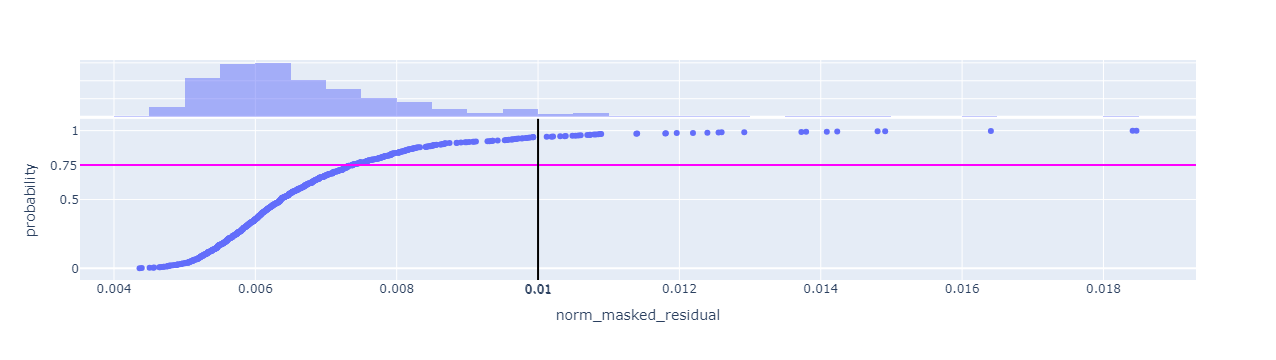

In [26]:
fig = px.ecdf(graphing_df, 
              x = nmr, 
              markers = True, 
              lines = False, 
              #facet_col = "Run ", 
              marginal = "histogram") #, facet_col_wrap = 1) # 

yval = 0.75
fig.add_hline(y = yval, 
              row = 1,
              col = 1,
              line_color = "magenta",
              annotation_text=f"{yval}", #from Run7", 
              annotation_position="left")

# fig.add_hline(y = 0.69,
#               row = 1,
#               col = 2,
#               line_color = "cyan",
#               annotation_text="0.78", # from Run6", 
#               annotation_position="right")

cutoff_val = 0.01
fig.add_vline(x = cutoff_val, 
              row = 1,
              line_color = "black",
              annotation_text= f"{cutoff_val}", 
              annotation_position="bottom")

# fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim)), mode = "lines"))
# fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75, mode = "lines"))

# fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim))))
# fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75))


fig.show()

In [207]:
#print(norms_df.iloc[:10])

In [22]:
total_gal = len(glob.glob(pj(out_dir, "123*/")))

In [27]:
#print(len(test_list), len(norms), 717/809*100)
#cutoff_val = 0.009
# run2_name = run2_name.strip()
# run6_name = run6_name.strip()
run_name = run_name.strip()

print(f"Total number of galaxies attempted: {total_gal}")
print()
print(f"Number of Galfit models generated...")
#print(f"{run2_name} : {len(norms2_df)}/{total_gal}")
#print(f"{run6_name}: {len(norms6_df)}/{total_gal}")
print(f"{run_name}: {len(norms_df)}/{total_gal}, {100*len(norms_df)/total_gal:.2f}%")

# cutoff2 = norms2_df.query(f"{nmr} < {cutoff_val}")
# cutoff6 = norms6_df.query(f"{nmr} < {cutoff_val}")
cutoff = norms_df.query(f"{nmr} < {cutoff_val}")
print()
print(f"Residuals below {cutoff_val} cutoff (excluding failures)...")
# print(f"{run2_name} : {len(cutoff2)}/{len(norms2_df)}, {100*len(cutoff2)/len(norms2_df):.2f}%")
# print(f"{run6_name}: {len(cutoff6)}/{len(norms6_df)}, {100*len(cutoff6)/len(norms6_df):.2f}%")
print(f"{run_name}: {len(cutoff)}/{len(graphing_df)}, {100*len(cutoff)/len(graphing_df):.2f}%")

Total number of galaxies attempted: 1000

Number of Galfit models generated...
Arm Cutoff: 815/1000, 81.50%

Residuals below 0.01 cutoff (excluding failures)...
Arm Cutoff: 762/799, 95.37%


In [28]:
def generate_images(input_df, png_dir:str, cutoff_val = 0.01, custom_range = None):
    images_below_cutoff = []
    images_above_cutoff = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 50) 
    
    for index_num in custom_range:
        g_nmr = input_df.iloc[index_num]
        gname = g_nmr.name
        nmr = g_nmr.norm_masked_residual

        # iloc returns a series, name returns the name of the row

        
        # print(f"chi^2/nu = {galaxy_info['chi^2_nu']:.2f}")
        # print(f"chi^2 = {galaxy_info['chi^2']:.2f}")
        print(f"{gname}, sorted #: {index_num}")
        print(f"Norm masked residual = {nmr:.6f}")
        #print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        #print(f"Norm GALFIT residual = {norm_galfit_residual:.4f}")


        # galfit_cmap = grayscale_cmap('RdBu')
        # residual_plot = plt.imshow(np.flipud(masked_residual[:,:])) #, norm=colors.LogNorm())
        # residual_plot.set_cmap('Greys')
        # residual_plot.set_cmap(galfit_cmap)
        # cbar = plt.colorbar()

        #plt.imshow(residual_plot)
        #imgplot = plt.imshow(arr[:, :, 0])
        height = 500
        width = 500
        size = (height, width)
        #out_str = galaxy_info.name.replace("galfit_out.fits", "combined.png").strip()
        out_str = f"{gname}_combined.png"
        #print(out_str)
        if nmr < cutoff_val:
            images_below_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_below_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
        else:
            images_above_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_above_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
            
    return images_below_cutoff, images_above_cutoff

In [29]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
# Could also be useful https://eltos.github.io/gradient/#FFFFFF-A5A5A5-000000-A5A5A5-FFFFFF
# png_dir6 = os.path.join(run_path6, sparc_out, galfit_out, "galfit_png/")
# images_below_cutoff, images_above_cutoff = generate_images(norms6_df, png_dir6, cutoff = 0.1)
png_dir = os.path.join(run_path, out_dir, "galfit_png")
#images_below_cutoff, images_above_cutoff = generate_images(norms7_df, png_dir7, cutoff = 0.8)
below, above = generate_images(norms_df, png_dir, cutoff_val = cutoff_val)#, custom_range = range(0, 30))

1237671262278582530, sorted #: 0
Norm masked residual = 0.004362



In [37]:
gname = "1237665566076240061"
gname_fits = OutputFits(pj(out_dir, gname, gname + "_galfit_out.fits"))
print(gname_fits.feedme.arms)

R0) power               # PA rotation func. (power, log, none)
R1) 0.0000      0       # Spiral inner radius [pixels]
R2) 9.2383      0       # Spiral outer radius [pixels]
R3) -21.5247    1       # Cumul. rotation out to outer radius [degrees]
R4) 14.5168     1       # Asymptotic spiral powerlaw
R9) -70.7128    1       # Inclination to L.o.S. [degrees]
R10) 147.6792    1      # Sky position angle



In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
size_sorted2 = norms2_df.sort_values(by=['image_size'])[::-1]
size_sorted6 = norms6_df.sort_values(by=['image_size'])[::-1]

In [ ]:
png_dir2 = os.path.join(run_path2, sparc_out, galfit_out, "galfit_png/")
top_10_by_size2, _ = generate_images(size_sorted2, png_dir2, cutoff = 0.004, custom_range = range(10))
print("=============================================\n")
top_10_by_size6, _ = generate_images(size_sorted6, png_dir6, cutoff = 0.004, custom_range = range(10))

In [ ]:
display(*top_10_by_size6)

In [ ]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

In [ ]:
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)